# BERT Classifier - easiest version

In [27]:
# setup - load packages
import pandas as pd
from datasets import Dataset
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer


seed = 13

# load data
preprocessed_data = pd.read_csv("/content/classifier_data_A.csv")
#preprocessed_data = pd.read_csv("../data/classifier_data_A.csv")

In [28]:
# Load Model
model_name = "bert-base-german-cased"
num_labels = 6
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels= num_labels) # classification head with one linear layer and num_label outputs is added on top of model here.

print(f"Model parameters: {model.num_parameters():,}")

# quantized?!

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 109,085,958


In [29]:
party_to_id = {party: i for i, party in enumerate(sorted(preprocessed_data['label'].unique()))}
preprocessed_data['label'] = preprocessed_data['label'].map(party_to_id)


# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(preprocessed_data)

# Tokenize
def tokenize(batch):
    return tokenizer(batch['speech_text'], truncation=True, padding=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")  # required name
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

dataset = dataset.train_test_split(test_size=0.3)  # 90% train, 10% val
train_dataset = dataset['train']
val_and_test_dataset = dataset['test']
val_and_test_dataset = val_and_test_dataset.train_test_split(test_size=0.5)  # 90% train, 10% val
val_dataset = val_and_test_dataset['train']
test_dataset = val_and_test_dataset['test']

Map:   0%|          | 0/36117 [00:00<?, ? examples/s]

In [30]:
# fine-tunen
training_args = TrainingArguments(
    output_dir="./bert-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)
%pip install evaluate
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# train
trainer.train()


/tmp/ipython-input-1549188525.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.950500,0.886463,0.654670
2,0.677600,0.789510,0.695460
3,0.406600,0.853719,0.716870


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=9483, training_loss=0.7673016710773143, metrics={'train_runtime': 1706.8328, 'train_samples_per_second': 44.435, 'train_steps_per_second': 5.556, 'total_flos': 1.9955848447973376e+16, 'train_loss': 0.7673016710773143, 'epoch': 3.0})

In [32]:
# validaten

trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.8537186980247498,
 'eval_accuracy': 0.7168696936138796,
 'eval_runtime': 36.3264,
 'eval_samples_per_second': 149.148,
 'eval_steps_per_second': 18.664,
 'epoch': 3.0}

In [33]:
def predicting_probs_to_preds(model, text, tokenizer=tokenizer, max_length=max_length):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)

    # Move inputs to the same device as the model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
    return pred, probs.squeeze().tolist()  # return list of class probabilities


In [34]:
# collect evaluation data
def evaluate_model(model, data):
    prediction_list = []
    probability_list = []
    true_label_list = []

    for i, row in data.iterrows():
        speech = row["speech_text"]
        pred, probs = predicting_probs_to_preds(model, speech)
        true_label = row["labels"]
        prediction_list.append(pred)
        probability_list.append(probs)
        true_label_list.append(true_label)

        if (i+1) % 100 == 0:
            print(f"Processed samples {i+1} of {len(data)} samples.")

    return prediction_list, probability_list, true_label_list


# define function to display eval metrics
def get_metrics(true_labels, preds):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Processed samples 100 of 5418 samples.
Processed samples 200 of 5418 samples.
Processed samples 300 of 5418 samples.
Processed samples 400 of 5418 samples.
Processed samples 500 of 5418 samples.
Processed samples 600 of 5418 samples.
Processed samples 700 of 5418 samples.
Processed samples 800 of 5418 samples.
Processed samples 900 of 5418 samples.
Processed samples 1000 of 5418 samples.
Processed samples 1100 of 5418 samples.
Processed samples 1200 of 5418 samples.
Processed samples 1300 of 5418 samples.
Processed samples 1400 of 5418 samples.
Processed samples 1500 of 5418 samples.
Processed samples 1600 of 5418 samples.
Processed samples 1700 of 5418 samples.
Processed samples 1800 of 5418 samples.
Processed samples 1900 of 5418 samples.
Processed samples 2000 of 5418 samples.
Processed samples 2100 of 5418 samples.
Processed samples 2200 of 5418 samples.
Processed samples 2300 of 5418 samples.
Processed samples 2400 of 5418 samples.
Processed samples 2500 of 5418 samples.
Processed

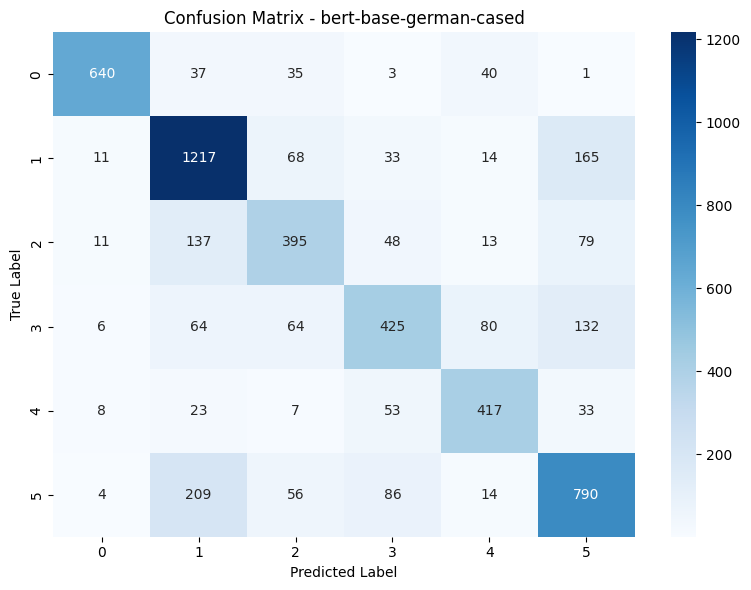

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Processed samples 100 of 5418 samples.
Processed samples 200 of 5418 samples.
Processed samples 300 of 5418 samples.
Processed samples 400 of 5418 samples.
Processed samples 500 of 5418 samples.
Processed samples 600 of 5418 samples.
Processed samples 700 of 5418 samples.
Processed samples 800 of 5418 samples.
Processed samples 900 of 5418 samples.
Processed samples 1000 of 5418 samples.
Processed samples 1100 of 5418 samples.
Processed samples 1200 of 5418 samples.
Processed samples 1300 of 5418 samples.
Processed samples 1400 of 5418 samples.
Processed samples 1500 of 5418 samples.
Processed samples 1600 of 5418 samples.
Processed samples 1700 of 5418 samples.
Processed samples 1800 of 5418 samples.
Processed samples 1900 of 5418 samples.
Processed samples 2000 of 5418 samples.
Processed samples 2100 of 5418 samples.
Processed samples 2200 of 5418 samples.
Processed samples 2300 of 5418 samples.
Processed samples 2400 of 5418 samples.
Processed samples 2500 of 5418 samples.
Processed

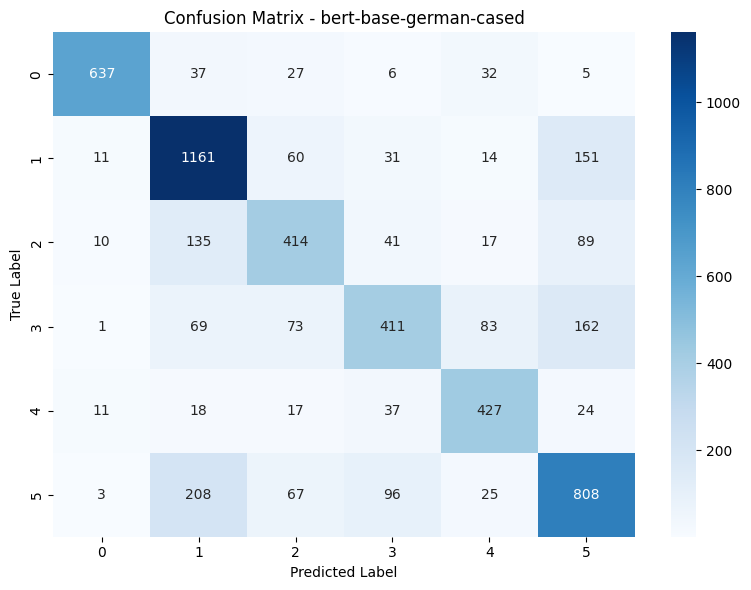

Evaluation on test set:


In [35]:
# evaluate model performance

val_df = val_dataset.to_pandas()
test_df = test_dataset.to_pandas()

# Evaluate on validation set
val_preds, val_probs, val_labels = evaluate_model(model, val_df)
print("Evaluation on val set:")
get_metrics(val_labels, val_preds)
# Evaluate on test set
test_preds, test_probs, test_labels = evaluate_model(model, test_df)
get_metrics(test_labels, test_preds)
print("Evaluation on test set:")


In [36]:
id_to_party = {v: k for k, v in party_to_id.items()}

def create_eval_df(preds, probs, labels, df, id_to_party):
    def decode(x):
        return id_to_party[x] if isinstance(x, int) else x

    return pd.DataFrame({
        "speech_text": df["speech_text"],
        "true_label": [decode(i) for i in labels],
        "predicted_label": [decode(i) for i in preds],
        "probabilities": probs
    })

In [37]:
val_eval_df = create_eval_df(val_preds, val_probs, val_labels, val_df, id_to_party)
test_eval_df = create_eval_df(test_preds, test_probs, test_labels, test_df, id_to_party)
val_eval_df.to_csv("/content/classifier_val_results.csv", index=False)
test_eval_df.to_csv("/content/classifier_test_results.csv", index=False)

In [38]:
# save fine-tuned model
model.save_pretrained("vanilla-bert-party-classifier/")
tokenizer.save_pretrained("vanilla-bert-party-classifier/")

('vanilla-bert-party-classifier/tokenizer_config.json',
 'vanilla-bert-party-classifier/special_tokens_map.json',
 'vanilla-bert-party-classifier/vocab.txt',
 'vanilla-bert-party-classifier/added_tokens.json',
 'vanilla-bert-party-classifier/tokenizer.json')